In [62]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import multilabel_confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from skmultilearn.adapt import MLkNN
from sklearn.multioutput import ClassifierChain
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
     
from nltk.stem.snowball import SnowballStemmer

import pandas as pd
import json
import os
import re

import gensim 
from gensim.models import Word2Vec
import gensim.downloader

import pickle 

import nltk
from nltk.tokenize import word_tokenize

import spacy
import matplotlib
import plotly.express as px
import plotly.subplots as sp
from plotly.subplots import make_subplots
from ast import literal_eval
from tqdm import tqdm

import sklearn.metrics
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [63]:
tqdm.pandas()

In [64]:
rcatt_data = '../data/rcatt_training_data_original.csv'
scraped_data = '../data/training_dataset_full.csv'

In [65]:
# transform into dataframes: 

df_r = pd.read_csv(rcatt_data).reset_index(drop = True)
df_r = df_r[~df_r['Text'].duplicated()]
df_s = pd.read_csv(scraped_data).reset_index(drop = True).rename(columns={'text': 'Text'})

In [66]:
# Converting from string to list using literal_eval:

for col in ['mitre_domain', 'tech_name', 'tech_id', 'tactic_id', 'software_id']:
    df_s[col] = df_s[col].apply(literal_eval)

In [67]:
mlb = MultiLabelBinarizer()
Y_s = mlb.fit_transform(df_s['tech_id'])
Y_s = pd.DataFrame(Y_s, columns=mlb.classes_)

In [68]:
mlb = MultiLabelBinarizer()
Y_s_tactic = mlb.fit_transform(df_s['tactic_id'])
Y_s_tactic = pd.DataFrame(Y_s_tactic, columns=mlb.classes_)

In [69]:
X_r = df_r['Text']
Y_r = df_r[[col for col in df_r.columns if col.startswith('T') and col[1:].isdecimal()]]

In [70]:
Y_r_tactic = df_r[[col for col in df_r.columns if col.startswith('TA')]]
s_r = list(set(Y_s.columns).difference(set(Y_r.columns)))
r_s = list(set(Y_r.columns).difference(set(Y_s.columns)))
rs = list(set(Y_s.columns).intersection(set(Y_r.columns)))

## Visualisation of data before dropping techniques: 

<AxesSubplot:>

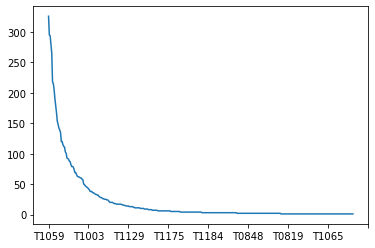

In [10]:
Y_s.sum(axis=0).sort_values(ascending=False).plot() # the one I collected 

<AxesSubplot:>

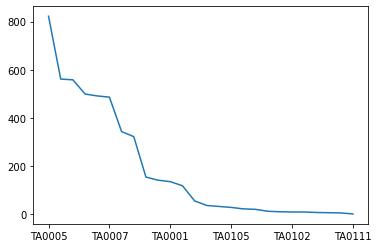

In [11]:
Y_s_tactic.sum(axis=0).sort_values(ascending=False).plot() # the one I collected 

## Merge datasets:

In [71]:
Y1 = Y_s[rs]
Y1[r_s] = 0
Y_s = Y1[Y1.sum(axis=1)>0] 
X_s = df_s['Text']
X_s = X_s[Y1.sum(axis=1)>0] # all urls who map at least one of the techniques in Y1
Y_s_tactic = Y_s_tactic[Y1.sum(axis=1)>0]

/tmp/ipykernel_437460/1701853409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y1[r_s] = 0
/tmp/ipykernel_437460/1701853409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y1[r_s] = 0
/tmp/ipykernel_437460/1701853409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

## Split data:

In [72]:
X_r_train, X_test_text, Y_r_train, Y_test, Y_r_train_tactic, Y_test_tactic = train_test_split(X_r, Y_r, Y_r_tactic, test_size=0.3,
                                                    random_state = 10)

In [73]:
X_train_text = pd.concat([X_r_train, X_s]).reset_index(drop=True)

In [74]:
Y_train = pd.concat([Y_r_train, Y_s]).reset_index(drop=True)

In [75]:
Y_train_tactic = pd.concat([Y_r_train_tactic, Y_s_tactic]).reset_index(drop=True)

In [76]:
Y_train_tactic = Y_train_tactic.dropna(axis=1)

In [77]:
# call methods for feature extraction and evaluation:
import sys
sys.path.append('../src')

from feature_extraction import feature_extraction, evaluation

In [78]:
X_train, X_test = feature_extraction('TfIdfVectorizer', X_train_text, X_test_text)

/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/vol/bitbucket/lgf21/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [79]:
similarities = cosine_similarity(X_train, X_test)

In [80]:
duplicates = set()
for i in range(similarities.shape[0]):
    for j in range(similarities.shape[1]):
        if similarities[i][j] > 0.9:
            # print(i, j, similarities[i][j])
            duplicates.add(i)

In [81]:
X_train_text = X_train_text[~X_train_text.index.isin(duplicates)]
X_train = X_train[~X_train.index.isin(duplicates)]
Y_train = Y_train[~Y_train.index.isin(duplicates)]
Y_train_tactic = Y_train_tactic[~Y_train_tactic.index.isin(duplicates)]

In [20]:
# save as pickle without preprocessing:

with open('merged_data_no_duplicates.pickle', 'wb') as handle:
    pickle.dump((X_train_text, X_test_text, Y_train_tactic, Y_test_tactic, Y_train, Y_test), handle, protocol=pickle.HIGHEST_PROTOCOL)

# Preprocessing:

In [82]:
nlp = spacy.load("en_core_web_sm", disable=['ner']) 

In [83]:
# Lemmatisation: 

X_train_text = X_train_text.apply(lambda x: x if len(x)> 1000000 else " ".join([y.lemma_ for y in nlp(x)]))
X_test_text = X_test_text.apply(lambda x: x if len(x)> 1000000 else " ".join([y.lemma_ for y in nlp(x)]))

In [84]:
# save as pickle with lemmatisation

with open('merged_data_lemma.pickle', 'wb') as handle:
    pickle.dump((X_train_text, X_test_text, Y_train_tactic, Y_test_tactic, Y_train, Y_test), handle, protocol=pickle.HIGHEST_PROTOCOL)